## 라이브러리 import

In [1]:
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import optuna
from optuna.samplers import TPESampler
from tqdm import tqdm


plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
sns.set(font_scale = 1)  
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("Let's start!")

Let's start!


<br>

## 데이터 로드

데이터는 train, test 데이터 모두 3231개의 행으로 이루어져 있습니다.

독립변수는 총 12개, 종속변수는 quality입니다.

In [2]:
train = pd.read_csv("./dataset/train.csv", index_col='id')
test = pd.read_csv("./dataset/test.csv", index_col='id')

display(train.shape, train.head(3), test.shape, test.head(3))

(3231, 13)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
id,,,,,,,,,,,,,
1,8.0,0.18,0.37,1.3,0.040,15.0,96.0,0.99120,3.06,0.61,12.1,white,6
2,7.5,0.38,0.29,4.9,0.021,38.0,113.0,0.99026,3.08,0.48,13.0,white,7
3,6.1,0.27,0.33,2.2,0.021,26.0,117.0,0.98860,3.12,0.30,12.5,white,6


(3231, 12)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
id,,,,,,,,,,,,
1,7.3,0.31,0.25,6.65,0.032,30.0,138.0,0.99244,2.90,0.37,11.1,white
2,8.7,0.70,0.24,2.50,0.226,5.0,15.0,0.99910,3.32,0.60,9.0,red
3,6.9,0.63,0.01,2.40,0.076,14.0,39.0,0.99522,3.34,0.53,10.8,red


<br>


각각의 변수들에 대한 설명은 다음과 같습니다.

* id : 식별 고유값 --> 데이터의 인덱스로만 사용할 것입니다.

* fixed acidity : 고정(비휘발성) 산도: 와인과 관련된 대부분의 산

* volatile acidity : 휘발성 산도: 와인에 함유된 아세트산의 양. 너무 높으면 불쾌한 식초 맛이 날 수 있음

* citric acid : 구연산: 소량으로 발견되며, 와인에 풍미를 더할 수 있음

* residual sugar : 잔여 당분: 발효가 멈춘 후 남은 설탕의 양으로 1g/L 미만의 와인은 드물며 45g/L 이상의 와인은 단맛으로 간주함

* chlorides : 염소화물: 와인의 염분량

* free sulfur dioxide : 유리 이산화황: 미생물의 성장과 와인의 산화를 방지함

* total sulfur dioxide : 총 이산화황: 저농도에서는 대부분 맛이 나지 않으나 50ppm 이상의 농도에서 맛에서 뚜렷하게 나타남

* density : 밀도: 알코올 및 당 함량에 따라 변함

* pH : 산성 또는 염기성 정도. 0(매우 산성) ~ 14(매우 염기성). 대부분의 와인은 pH 3-4 사이임

* sulphates : 황산염: 이산화황 농도에 기여할 수 있는 와인 첨가제. 항균 및 항산화제로 작용

* alcohol : 와인의 알코올 함량 백분율

* type : 와인에 사용된 포도의 종류. Red(적포도주), White(백포도주)로 나뉨

* quality : 맛으로 평가된 와인의 품질

<br>

## EDA


### 데이터 기본 정보


단순히 `train.info()` 만으로도 충분히 볼 수 있는 데이터이지만, 변수의 수가 100개가 넘는 데이터를 다룰 일들도 생길 것입니다.

변수의 수가 굉장히 많으면 `.info()` 메서드로는 출력이 안 될 수도 있는데요,

따라서 간단한 for문을 이용해서 각 변수의 고유한 값의 갯수까지 한 눈에 파악할 수 있도록 아래와 같이 구현해 보았습니다. 

In [3]:
train_info = pd.DataFrame(columns = ['Name of Col', 'Name of Null', 'Dtype', 'N_Unique'])

for i in range(0, len(train.columns)):
    train_info.loc[i] = [train.columns[i],
                        train[train.columns[i]].isnull().sum(),
                        train[train.columns[i]].dtypes,
                        train[train.columns[i]].nunique()]
    
train_info

,Name of Col,Name of Null,Dtype,N_Unique
0,fixed acidity,0,float64,99
1,volatile acidity,0,float64,159
2,citric acid,0,float64,86
3,residual sugar,0,float64,277
4,chlorides,0,float64,168
5,free sulfur dioxide,0,float64,115
6,total sulfur dioxide,0,float64,260
7,density,0,float64,806
8,pH,0,float64,105
9,sulphates,0,float64,101


In [4]:
test_info = pd.DataFrame(columns = ['Name of Col', 'Name of Null', 'Dtype', 'N_Unique'])

for i in range(0, len(test.columns)):
    test_info.loc[i] = [test.columns[i],
                        test[test.columns[i]].isnull().sum(),
                        test[test.columns[i]].dtypes,
                        test[test.columns[i]].nunique()]
    
test_info

,Name of Col,Name of Null,Dtype,N_Unique
0,fixed acidity,0,float64,92
1,volatile acidity,0,float64,159
2,citric acid,0,float64,84
3,residual sugar,0,float64,265
4,chlorides,0,float64,171
5,free sulfur dioxide,0,float64,106
6,total sulfur dioxide,0,float64,258
7,density,0,float64,816
8,pH,0,float64,100
9,sulphates,0,float64,97


<br>

1. null data는 없음

2. type컬럼만 object type. 향후 onehot encoding 또는 label encoding

<br>

<br>

### 종속변수의 분포

타겟변수인 quality의 불균형이 높은 편.

1. 4와 8은 각각 약 3%로 분포

2. 5와 6을 합쳐서 76.8%로 분포

3. 모델이 5와 6으로만 지나치게 예측할 가능성이 높음


<br>

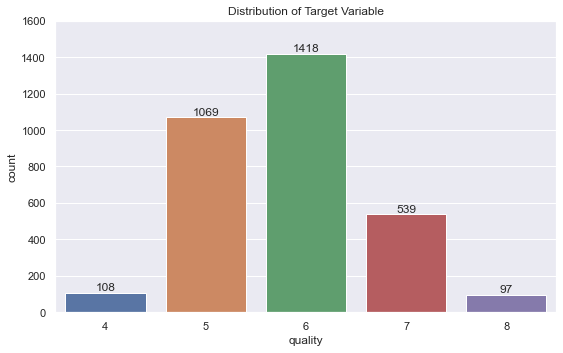

In [5]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(train['quality'])

ax.bar_label(ax.containers[0])
plt.title("Distribution of Target Variable")
ax.set_ylim(0, 1600)

plt.show()

In [6]:
train.quality.value_counts(normalize=True)

6    0.438873
5    0.330857
7    0.166821
4    0.033426
8    0.030022
Name: quality, dtype: float64

<br>

### 수치형 변수 분포

수치형 변수들의 분포를 train과 test 함께 비교해본 결과, train과 test가 거의 비슷하게 분포하고 있음을 알 수 있습니다.

왜도를 함께 확인한 결과, chlorides 변수를 제외하고는 치우침이 크지 않은 것으로 보입니다.(-2와 +2 사이가 기준)

변수 중에 치우친 변수가 있기 때문에 데이터 스케일링이 필요하다고 판단됩니다.



In [7]:
num_cols = list(train._get_numeric_data().columns[:-1])
df = pd.concat([train[num_cols], test[num_cols]], axis=0)
df['label'] = 'test'
df['label'][:3231] = 'train'

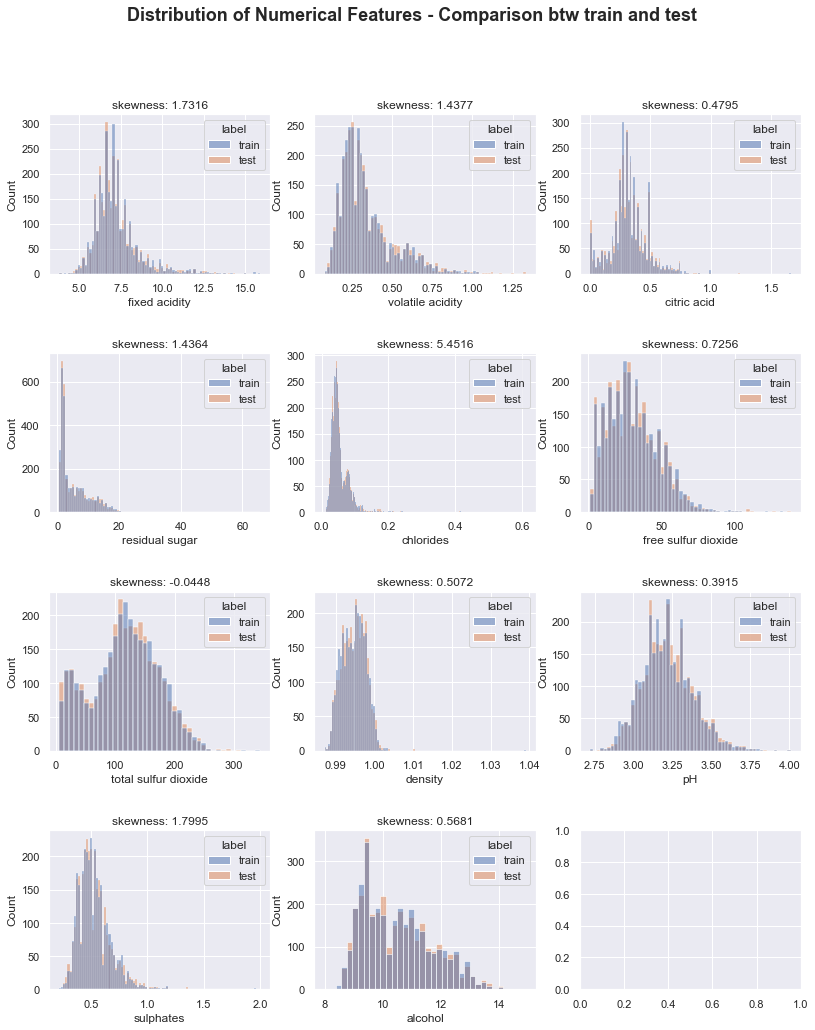

In [8]:
fig, axes = plt.subplots(4, 3, figsize = (12, 15), sharey=False)

for i, feature in enumerate(num_cols):
    sns.histplot(data = df, x = feature, hue = 'label', ax = axes[i//3][i%3])
    axes[i//3][i%3].set_title(f'skewness: {df[feature].skew():.4f}', fontsize = 12)
    plt.subplots_adjust(hspace = 0.5)
    
fig.suptitle('Distribution of Numerical Features - Comparison btw train and test', fontsize = 18,fontweight='bold')
plt.show()

<br>

### 범주형 변수 분포

train, test 데이터 간의 불균형은 없으나, red에 비해 white에 대한 비중이 3배 이상 높은 것으로 보입니다.



In [9]:
cat_col = 'type'
df2 = pd.concat([pd.DataFrame(train[cat_col]), pd.DataFrame(test[cat_col])])
df2['label'] = 'test'
df2['label'][:3231] = 'train'

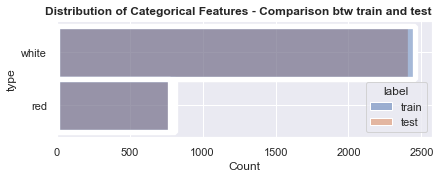

In [10]:
plt.figure(figsize = (6, 2))

sns.histplot(data = df2, y = 'type', hue = 'label')

plt.suptitle('Distribution of Categorical Features - Comparison btw train and test', fontsize = 12,fontweight='bold')
plt.show()

<br>

### 각 독립변수별 quality와의 관계 분석

각 변수들이 quality에 미치는 영향이 유의미한지를 확인해 보고자 합니다. 

<br>

In [11]:
# 피벗테이블 생성
def create_pivot(n):
    pivot_df = pd.pivot_table(data = train, index = 'quality', values = num_cols[n], aggfunc = ['mean', 'count'])
    pivot_df['ratio, %'] = round(pivot_df[('count', num_cols[n])] / len(train) * 100, 2)
    return pivot_df

# hist plot 생성
def create_plot(n):
    sns.histplot(data = train, x = num_cols[n], hue = 'quality', palette = 'colorblind')
    plt.show()

<br>

#### fixed acidity: 고정(비휘발성) 산도
+ 와인과 관련된 대부분의 산

<br>

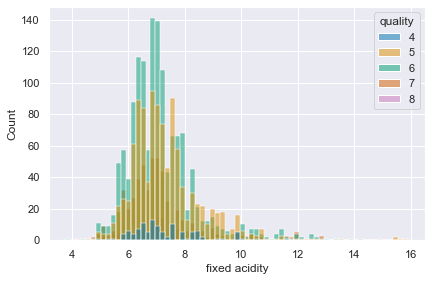

,mean,count,"ratio, %"
,fixed acidity,fixed acidity,
quality,,,
4,7.275926,108,3.34
5,7.339757,1069,33.09
6,7.161142,1418,43.89
7,7.127180,539,16.68
8,6.740206,97,3.00


None

In [12]:
display(create_pivot(0), create_plot(0))

<br>

#### volatile acidity : 휘발성 산도
+ 와인에 함유된 아세트산의 양. 너무 높으면 불쾌한 식초 맛이 날 수 있음

<br>

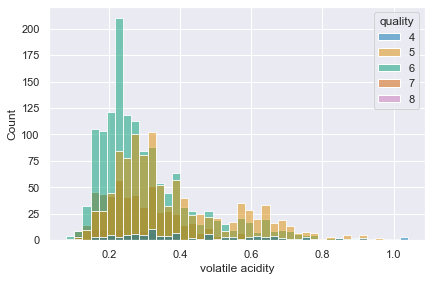

,mean,count,"ratio, %"
,volatile acidity,volatile acidity,
quality,,,
4,0.469028,108,3.34
5,0.383634,1069,33.09
6,0.309870,1418,43.89
7,0.292653,539,16.68
8,0.288196,97,3.00


None

In [13]:
display(create_pivot(1), create_plot(1))

<br>

#### citric acid : 구연산
+ 소량으로 발견되며, 와인에 풍미를 더할 수 있음

<br>

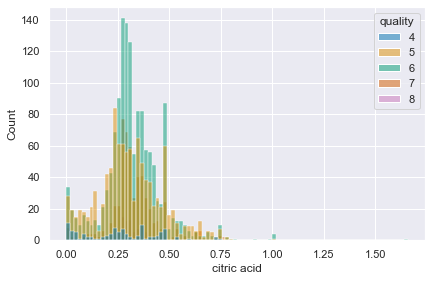

,mean,count,"ratio, %"
,citric acid,citric acid,
quality,,,
4,0.260926,108,3.34
5,0.313143,1069,33.09
6,0.323886,1418,43.89
7,0.331633,539,16.68
8,0.323093,97,3.00


None

In [14]:
display(create_pivot(2), create_plot(2))

<br>

#### residual sugar : 잔여 당분
+ 발효가 멈춘 후 남은 설탕의 양으로 1g/L 미만의 와인은 드물며 45g/L 이상의 와인은 단맛으로 간주함

<br>

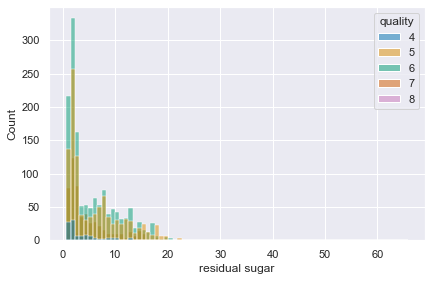

,mean,count,"ratio, %"
,residual sugar,residual sugar,
quality,,,
4,3.962037,108,3.34
5,5.889476,1069,33.09
6,5.548942,1418,43.89
7,4.679221,539,16.68
8,5.260309,97,3.00


None

In [15]:
display(create_pivot(3), create_plot(3))

<br>

#### chlorides: 염소화물
+ 와인의 염분량

<br>

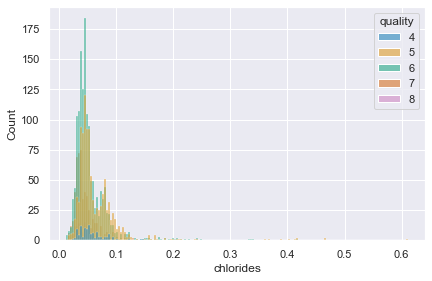

,mean,count,"ratio, %"
,chlorides,chlorides,
quality,,,
4,0.056972,108,3.34
5,0.064714,1069,33.09
6,0.054214,1418,43.89
7,0.045111,539,16.68
8,0.041825,97,3.00


None

In [16]:
display(create_pivot(4), create_plot(4))

<br>

#### free sulfur dioxide: 유리 이산화황
+ 미생물의 성장과 와인의 산화를 방지함

<br>

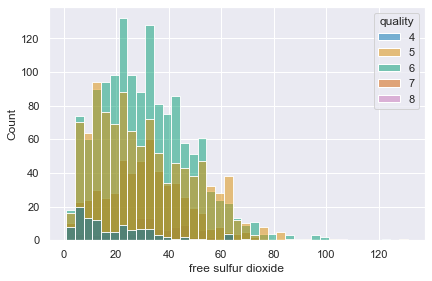

,mean,count,"ratio, %"
,free sulfur dioxide,free sulfur dioxide,
quality,,,
4,20.796296,108,3.34
5,30.526193,1069,33.09
6,30.960860,1418,43.89
7,30.725417,539,16.68
8,35.814433,97,3.00


None

In [17]:
display(create_pivot(5), create_plot(5))

<br>

#### total sulfur dioxide : 총 이산화황
+ 저농도에서는 대부분 맛이 나지 않으나 50ppm 이상의 농도에서 맛에서 뚜렷하게 나타남

<br>

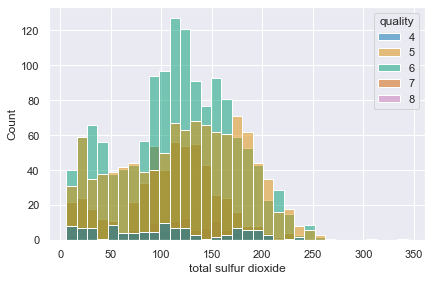

,mean,count,"ratio, %"
,total sulfur dioxide,total sulfur dioxide,
quality,,,
4,104.356481,108,3.34
5,121.696445,1069,33.09
6,115.722849,1418,43.89
7,108.591837,539,16.68
8,119.948454,97,3.00


None

In [18]:
display(create_pivot(6), create_plot(6))

<br>

#### density : 밀도
+ 알코올 및 당 함량에 따라 변함

<br>

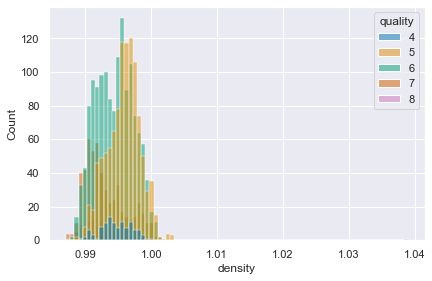

,mean,count,"ratio, %"
,density,density,
quality,,,
4,0.994770,108,3.34
5,0.995868,1069,33.09
6,0.994518,1418,43.89
7,0.993034,539,16.68
8,0.992576,97,3.00


None

In [19]:
display(create_pivot(7), create_plot(7))

<br>

#### pH : 산성 또는 염기성 정도
+ 0(매우 산성) ~ 14(매우 염기성). 대부분의 와인은 pH 3-4 사이임

<br>

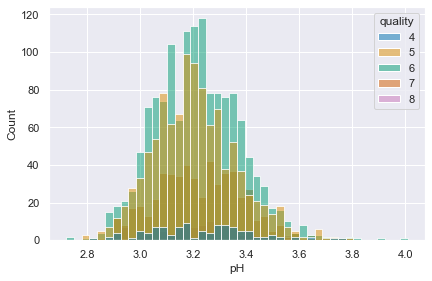

,mean,count,"ratio, %"
,pH,pH,
quality,,,
4,3.232870,108,3.34
5,3.204995,1069,33.09
6,3.213801,1418,43.89
7,3.225733,539,16.68
8,3.235464,97,3.00


None

In [20]:
display(create_pivot(8), create_plot(8))

<br>

#### sulphates : 황산염
+ 이산화황 농도에 기여할 수 있는 와인 첨가제. 항균 및 항산화제로 작용

<br>

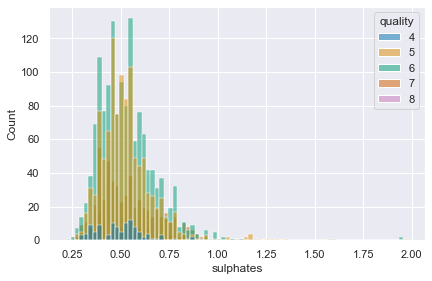

,mean,count,"ratio, %"
,sulphates,sulphates,
quality,,,
4,0.505833,108,3.34
5,0.529897,1069,33.09
6,0.531065,1418,43.89
7,0.542801,539,16.68
8,0.519794,97,3.00


None

In [21]:
display(create_pivot(9), create_plot(9))

<br>

#### alcohol : 와인의 알코올 함량. 백분율

<br>

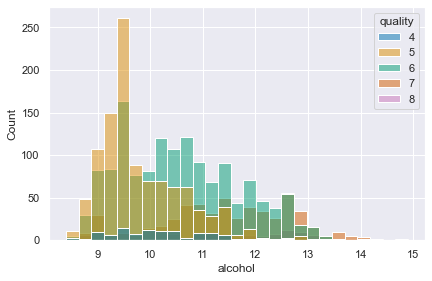

,mean,count,"ratio, %"
,alcohol,alcohol,
quality,,,
4,10.180556,108,3.34
5,9.846333,1069,33.09
6,10.578573,1418,43.89
7,11.445659,539,16.68
8,11.559794,97,3.00


None

In [22]:
display(create_pivot(10), create_plot(10))

<br>

#### type : 와인에 사용된 포도의 종류
+ Red(적포도주), White(백포도주)로 나뉨

<br>

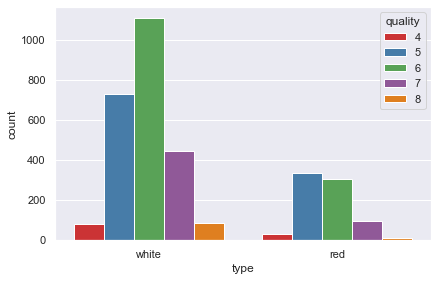

In [23]:
sns.countplot(data = train, x = 'type', hue = 'quality', palette = 'Set1')
plt.show()

<br>

#### 상관관계 분석

<br>

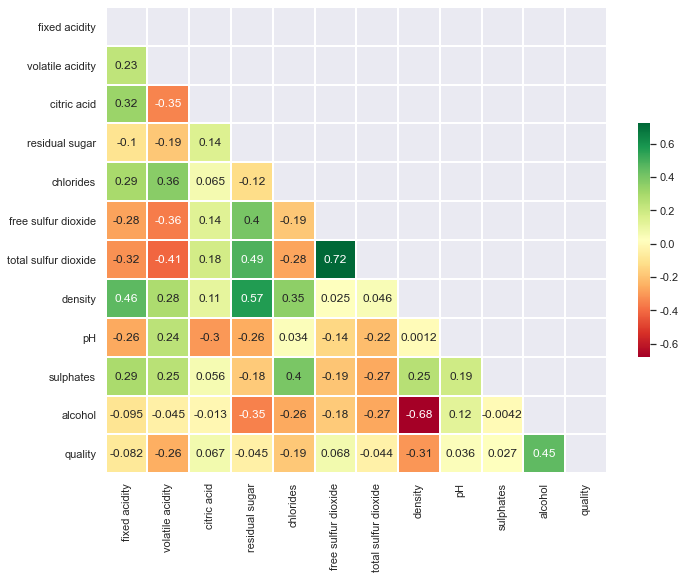

In [24]:
corr = train.corr()

plt.figure(figsize = (10, 8))

mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

heat_map = sns.heatmap(corr,
                       annot = True,
                       cmap = 'RdYlGn',
                       mask = mask,
                       linewidths = 0.01,
                       cbar_kws = {'shrink' : .5})

<br>

## 데이터 전처리

* type 변수: one-hot encoding으로 더미변수화
* numeric 변수: standard scaling으로 centering


In [25]:
# one-hot encoding

train = pd.get_dummies(train)
test = pd.get_dummies(test)

display(train.shape, train.head(1), test.shape, test.head(1))

(3231, 14)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
id,,,,,,,,,,,,,,
1,8.0,0.18,0.37,1.3,0.04,15.0,96.0,0.9912,3.06,0.61,12.1,6,0,1


(3231, 13)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
id,,,,,,,,,,,,,
1,7.3,0.31,0.25,6.65,0.032,30.0,138.0,0.99244,2.9,0.37,11.1,0,1


In [26]:
# standard scaling to make the numeric variables

ss = StandardScaler()

for col in num_cols:
    train[col] = ss.fit_transform(train[[col]])
    test[col] = ss.fit_transform(test[[col]])
    
display(train.head(2), test.head(2))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
id,,,,,,,,,,,,,,
1,0.613164,-0.973871,0.346320,-0.862826,-0.444893,-0.896417,-0.363344,-1.135570,-0.952533,0.524814,1.342873,6,0,1
2,0.227151,0.274102,-0.202257,-0.115217,-0.976867,0.426604,-0.058413,-1.443438,-0.828960,-0.343803,2.096877,7,0,1


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
id,,,,,,,,,,,,,
1,0.063011,-0.191206,-0.470589,0.258118,-0.707904,-0.022119,0.403475,-0.775939,-2.026277,-1.089432,0.515259,0,1
2,1.146747,2.162839,-0.539777,-0.624624,5.007836,-1.470535,-1.770665,1.489262,0.613957,0.462904,-1.248324,1,0


<br>

## 모델 생성

* train_test_split
* k-fold cross validation
* creating lgbm classifier
* model evaluation


In [27]:
X_trn = train.drop('quality', axis=1).reset_index(drop=True)
y_trn = train['quality'].reset_index(drop=True)
X_tst = test.reset_index(drop=True)

display(X_trn.shape, y_trn.shape, X_tst.shape)

(3231, 13)

(3231,)

(3231, 13)

In [28]:
# k-fold cross validation, trial with the default parameter.


RANDOM_SEED = 42
n_splits = 5
skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = RANDOM_SEED)

preds = []
mean_acc = 0

model = LGBMClassifier(random_state = RANDOM_SEED)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_trn, y_trn)):
    X_train, X_val = X_trn.loc[trn_idx], X_trn.loc[val_idx]
    y_train, y_val = y_trn.loc[trn_idx], y_trn.loc[val_idx]
    
    model.fit(X_train, y_train,
             verbose = False,
             eval_set = [(X_train, y_train), (X_val, y_val)],
             eval_metric = 'logloss',
             early_stopping_rounds = 100)
    
    y_preds = model.predict(X_val)
    score = accuracy_score(y_val, y_preds)
    mean_acc += score
    
    print(f"Fold {fold}'s score: {score}")
        
    preds.append(model.predict(X_tst))

print("==========================================")
print(f"Mean auc of all folds: {mean_acc / n_splits}")

Fold 0's score: 0.6043276661514683
Fold 1's score: 0.6207430340557275
Fold 2's score: 0.6068111455108359
Fold 3's score: 0.608359133126935
Fold 4's score: 0.631578947368421
Mean auc of all folds: 0.6143639852426774


<br>

## 예측 및 제출


In [29]:
preds = np.mean(preds, axis = 0)

final_preds = np.round(preds).astype('int64')

In [30]:
submission = pd.read_csv('./dataset/sample_submission.csv')

submission['quality'] = final_preds

In [31]:
submission.to_csv('./dataset/submission_baseline_.csv', index=False)